### Simple rule-based allocation of weights for a portfolio of stocks

In [1]:
import pandas as pd
import numpy as np 
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import permutations, combinations
%matplotlib inline

In [2]:
syms = ['^NSEI', 'NATIONALUM.NS', 'BHEL.NS', 'YESBANK.NS', 'GAIL.NS', 'MRPL.NS', 'ONGC.NS', 'SJVN.NS', 'TATAPOWER.NS']
price_df = pd.read_csv('datasets/nse_equities_20160101_20201130.csv')
price_df.reset_index(inplace=True)

In [3]:
df = price_df[['Date', 'sym', 'Adj Close']].copy()
df['price_ret'] = df['Adj Close']/df['Adj Close'].shift(1) - 1
df.dropna(axis=0, how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

stats_df = pd.DataFrame(columns=['symbol', 'sharpe', 'beta', 'mean_ret', 'std_ret'])
idx = 0 
for sym in syms:
    if sym == '^NSEI':
        continue
    
    ser1 = df[df['sym'] == sym]['price_ret'].reset_index(drop=True)
    ser2 = df[df['sym'] == '^NSEI']['price_ret'].reset_index(drop=True)
    sharpe = (ser1.mean()/ser2.std()) * pow(252, 0.5)
    beta   = ser1.cov(ser2) / ser2.var()
    mean_ret = ser1.mean()
    std_ret  = ser1.std()
    stats_df.loc[idx] = [sym, sharpe, beta, mean_ret, std_ret]
    idx += 1

stats_df

,symbol,sharpe,beta,mean_ret,std_ret
0,NATIONALUM.NS,-0.314371,0.199886,-0.000228,0.039298
1,BHEL.NS,1.114112,0.187938,0.000808,0.055154
2,YESBANK.NS,2.585878,0.084115,0.001876,0.097733
3,GAIL.NS,5.836542,0.080424,0.004235,0.135142
4,MRPL.NS,-0.808459,0.020589,-0.000587,0.028833
5,ONGC.NS,3.610249,0.227121,0.002619,0.099680
6,SJVN.NS,-0.465809,0.281746,-0.000338,0.027322
7,TATAPOWER.NS,2.034633,0.077946,0.001476,0.045325


In [4]:
sharpe_top_5   = stats_df.sort_values(['sharpe'], ascending=False)['symbol'].tolist()[:5]
beta_top_5     = stats_df.sort_values(['beta'], ascending=False)['symbol'].tolist()[:5]
beta_bottom_5  = stats_df.sort_values(['beta'], ascending=True)['symbol'].tolist()[:5]
mean_top_5     = stats_df.sort_values(['mean_ret'], ascending=False)['symbol'].tolist()[:5]
std_top_5      = stats_df.sort_values(['std_ret'], ascending=False)['symbol'].tolist()[:5]

In [5]:
def get_ret_df():
    ret_df = price_df[['Date', 'sym', 'Adj Close']].copy()
    ret_df = ret_df.pivot(index='Date', columns='sym', values='Adj Close')
    ret_df = ret_df/ret_df.shift(1) - 1
    
    return ret_df.dropna(axis=0, how='any')

In [44]:
def get_filt_df(df_type):
    if df_type == 1: 
        '''
        Arithmetic returns
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close')
        filt_df = filt_df/filt_df.shift(1) - 1

    elif df_type == 2:
        '''
        Volume change 
        '''
        filt_df = price_df[['Date', 'sym', 'Volume']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Volume')
        filt_df = filt_df/filt_df.shift(1) - 1 
        
    elif df_type == 3:
        '''
        MA5
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df['ma5'] = filt_df['Adj Close'].rolling(window=5).mean()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='ma5')
        filt_df = filt_df/filt_df.shift(1) - 1
    
    elif df_type == 4:
        '''
        MA20 
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df['ma20'] = filt_df['Adj Close'].rolling(window=20).mean()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='ma20')
        filt_df = filt_df/filt_df.shift(1) - 1
        
    elif df_type == 5:
        '''
        MA50
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df['ma50'] = filt_df['Adj Close'].rolling(window=50).mean()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='ma50')
        filt_df = filt_df/filt_df.shift(1) - 1
        
    elif df_type == 6: 
        '''
        MA120
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df['ma120'] = filt_df['Adj Close'].rolling(window=120).mean()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='ma120')
        filt_df = filt_df/filt_df.shift(1) - 1
        
    elif df_type == 7:
        '''
        AVG(MA20, MA50)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close')
        filt_df_ma20 = filt_df.rolling(window=20).mean().dropna(axis=0, how='any')
        filt_df_ma50 = filt_df.rolling(window=50).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma20 + filt_df_ma50)/2
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    elif df_type == 8:
        '''
        AVG(MA50, MA120)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close')
        filt_df_ma_50 = filt_df.rolling(window=50).mean().dropna(axis=0, how='any')
        filt_df_ma_120 = filt_df.rolling(window=120).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma_50 + filt_df_ma_120)/2
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    elif df_type == 9:
        '''
        AVG(MA20, MA120)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close')
        filt_df_ma_20 = filt_df.rolling(window=20).mean().dropna(axis=0, how='any')
        filt_df_ma_120 = filt_df.rolling(window=120).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma_20 + filt_df_ma_120)/2
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        
    elif df_type == 10: 
        '''
        AVG(MA20, MA50, MA120)
        '''
        filt_df = price_df[['Date', 'sym', 'Adj Close']].copy()
        filt_df = filt_df.pivot(index='Date', columns='sym', values='Adj Close')
        filt_df_ma_20 = filt_df.rolling(window=20).mean().dropna(axis=0, how='any')
        filt_df_ma_50 = filt_df.rolling(window=50).mean().dropna(axis=0, how='any')
        filt_df_ma_120 = filt_df.rolling(window=120).mean().dropna(axis=0, how='any')
        filt_df_merged = (filt_df_ma_20 + filt_df_ma_50 + filt_df_ma_120)/3 
        filt_df_merged = filt_df_merged.dropna(axis=0, how='any')
        filt_df = filt_df_merged/filt_df_merged.shift(1) - 1
        

    filt_df.dropna(axis=0, how='any', inplace=True)
    filt_df = filt_df.div(filt_df.sum(axis=1), axis=0)
    
    return filt_df

In [65]:
def return_pval_df(syms, value, rdf, idf): 
    print("In return_pval_df()")
    
    ret_cols  = list(rdf.columns)[1:]
    
    pval_cols = [ 'pval_' + val.replace('ret_','') for val in ret_cols ] 
    rdf.loc[:, pval_cols[0]] = rdf.loc[:, ret_cols[0]] * idf.loc[:, ret_cols[0]].shift(1) * value
    rdf.loc[:, pval_cols[1]] = rdf.loc[:, ret_cols[1]] * idf.loc[:, ret_cols[1]].shift(1) * value
    rdf.loc[:, pval_cols[2]] = rdf.loc[:, ret_cols[2]] * idf.loc[:, ret_cols[2]].shift(1) * value 
    rdf.loc[:, pval_cols[3]] = rdf.loc[:, ret_cols[3]] * idf.loc[:, ret_cols[3]].shift(1) * value 
    rdf['return'] = rdf[pval_cols[0]] + rdf[pval_cols[1]] + rdf[pval_cols[2]] + rdf[pval_cols[3]]
    
    rdf = rdf.replace([-np.inf, np.inf], np.nan).dropna(axis=0, how='any').reset_index(drop=True)
    
    pvalue_mean   = round(rdf['return'].mean(), 4)
    pvalue_std    = round(rdf['return'].std(), 4)
    pvalue_sharpe = round(pvalue_mean / pvalue_std * pow(252, 0.5), 4)
    
    return pvalue_mean, pvalue_std, pvalue_sharpe, rdf

In [75]:
def plot_pval(pval_df): 
    pval_df['return'].plot(grid=True, title='return', kind='line', rot='45')  
    plt.show()

In [70]:
def get_portfolio_data(value, syms, filt_df, ret_df):
    print("In get_portfolio_data()")
    
    ind_df, ret_value_df = filt_df[syms].copy(), ret_df[syms].copy()
    pvalue_mean, pvalue_std, pvalue_sharpe, pval_df  = return_pval_df(syms, value, ret_value_df, ind_df)
    
    print("Mean    : {}".format(pvalue_mean))
    print("Std     : {}".format(pvalue_std))
    print("Sharpe  : {}".format(pvalue_sharpe))
    
    plot_pval(pval_df)

In [68]:
def get_portfolio_stats(value, syms, df_type):
    ret_df  = get_ret_df()
    filt_df = get_filt_df(df_type)
    ret_df  = ret_df[ret_df.index.isin(filt_df.index.tolist())]
    get_portfolio_data(value, syms, filt_df, ret_df)

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0061
Std     : 0.4336
Sharpe  : 0.2233


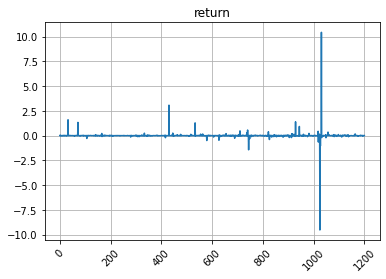

In [76]:
get_portfolio_stats(1, sharpe_top_5, 1)

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0049
Std     : 0.1449
Sharpe  : 0.5368


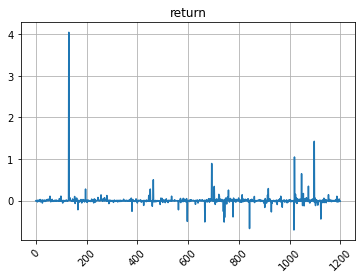

In [77]:
get_portfolio_stats(1, sharpe_top_5, 2)

In get_portfolio_data()
In return_pval_df()
Mean    : -0.0087
Std     : 0.194
Sharpe  : -0.7119


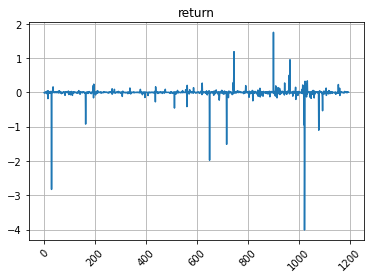

In [78]:
get_portfolio_stats(1, sharpe_top_5, 3)

In get_portfolio_data()
In return_pval_df()
Mean    : -0.0097
Std     : 0.3215
Sharpe  : -0.479


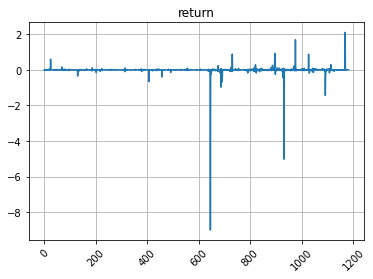

In [79]:
get_portfolio_stats(1, sharpe_top_5, 4)

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0025
Std     : 0.1452
Sharpe  : 0.2733


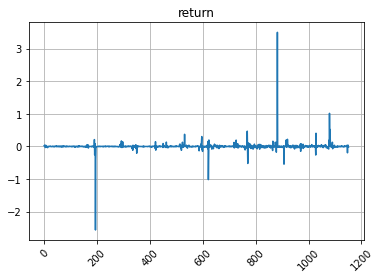

In [80]:
get_portfolio_stats(1, sharpe_top_5, 5)

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0072
Std     : 0.4857
Sharpe  : 0.2353


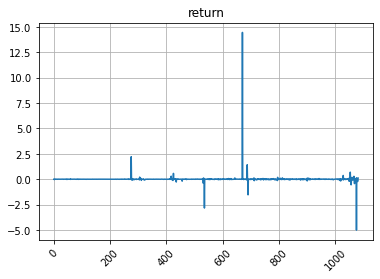

In [81]:
get_portfolio_stats(1, sharpe_top_5, 6)

In get_portfolio_data()
In return_pval_df()
Mean    : -0.0003
Std     : 0.0879
Sharpe  : -0.0542


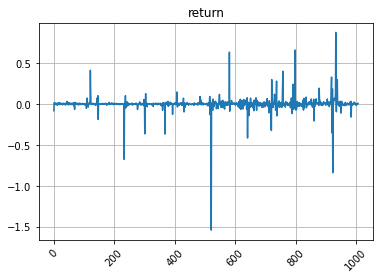

In [84]:
get_portfolio_stats(1, sharpe_top_5, 7)

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0051
Std     : 0.0933
Sharpe  : 0.8677


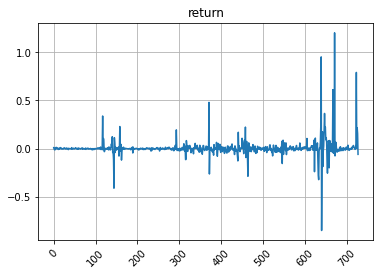

In [85]:
get_portfolio_stats(1, sharpe_top_5, 8)

In get_portfolio_data()
In return_pval_df()
Mean    : 0.0264
Std     : 0.7322
Sharpe  : 0.5724


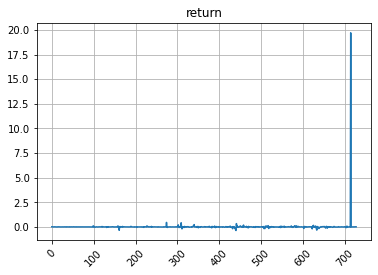

In [86]:
get_portfolio_stats(1, sharpe_top_5, 9)

In get_portfolio_data()
In return_pval_df()
Mean    : -0.0003
Std     : 0.0822
Sharpe  : -0.0579


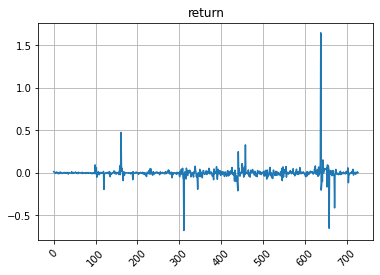

In [87]:
get_portfolio_stats(1, sharpe_top_5, 10)